## Introduction

This is the ***second*** of a series where I look at big datasets, and in each case I'm using a different tool to carry out the same analysis on the same dataset.

This time I'm using the **Dask library** for parallel computing to manage a large file size. You can find each notebook in the series in my [Github repo](https://github.com/jlad26/london-smart-energy), including:
1. Pandas chunksize
1. Dask library

There is a little more explanation in the first notebook (Pandas chunksize) on the overall approach to the analysis. In the other notebooks I focus more on the elements specific to the tool being used.

## Dataset description

Throughout the series we'll use the [SmartMeter Energy Consumption Data in London Households](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households) dataset, which according to the website contains:
>Energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014.

The households were divided into two groups:
- Those who were sent Dynamic Time of Use (dToU) energy prices (labelled "High", "Medium", or "Low") a day in advance of the price being applied.
- Those who were subject to the Standard tariff.

One aim of the study was to see if pricing knowledge would affect energy consumption behaviour.

## Results

<img src="images/result1.png" width="100%"/>

The results show the expected seasonal variation with a clear difference between the two groups, suggesting that energy price knowledge does indeed help reduce energy consumption.

The rest of the notebook shows how this chart was produced from the raw data.

## Introduction to Dask

According to the docs:
>*Dask is a flexible library for parallel computing in Python*
>
>Dask is composed of two parts:
>
>- Dynamic task scheduling optimized for computation. This is similar to Airflow, Luigi, Celery, or Make, but optimized for interactive computational workloads.
>
>- “Big Data” collections like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of dynamic task schedulers.

This means that not only can we process larger-than-memory files, but unlike the pandas chunksize approach, we can also make use of clusters - or multiple CPU cores when working on a single machine.

## Accessing the data

The data is downloadable as a single zip file which contains a csv file of 167 million rows. If the `curl` command doesn't work (and it will take a while as it's a file of 800MB), you can download the file [here](https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/3527bf39-d93e-4071-8451-df2ade1ea4f2/LCL-FullData.zip) and put it in the folder `data` which is in the folder where this notebook is saved.

In [ ]:
!curl "https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/3527bf39-d93e-4071-8451-df2ade1ea4f2/LCL-FullData.zip" --location --create-dirs -o "data/LCL-FullData.zip"

First we unzip the data. This may take a while! Alternatively you can unzip it manually using whatever unzip utility you have. Just make sure the extracted file is in a folder called `data` within the folder where your notebook is saved.

In [1]:
!unzip "data/LCL-FullData.zip" -d "data"

Archive:  data/LCL-FullData.zip
  inflating: data/CC_LCL-FullData.csv  


## Examining the data

In [2]:
import pandas as pd
from dask import dataframe as dd

Now let's load the data into a Dask dataframe.

In [3]:
raw_data_ddf = dd.read_csv('data/CC_LCL-FullData.csv')
raw_data_ddf

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
npartitions=133,,,,
,object,object,object,int64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


Viewing the dataframe shows that Dask has divided our data into 133 partitions. Dask has also "guessed" the data types by taking a sample of data. Leaving the dataframe as it is will eventually cause errors, because the kWh data is a mix of numbers and 'Null' string values.

As a first step we can specify the kWh data type, using `object` to handle strings.

In [4]:
raw_data_ddf = dd.read_csv(
    'data/CC_LCL-FullData.csv',
    dtype={'KWH/hh (per half hour) ': 'object'}
)
raw_data_ddf

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
npartitions=133,,,,
,object,object,object,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


We rename the columns to make them more readable.

In [5]:
col_renaming = {
    'LCLid' : 'Household ID',
    'stdorToU' : 'Tariff Type',
    'KWH/hh (per half hour) ' : 'kWh'
}
full_data_ddf = raw_data_ddf.rename(columns=col_renaming)

Let's work on a small subset of the data (10,000 rows) to develop each processing step.

In [6]:
test_data = full_data_ddf.head(10000)
test_data

,Household ID,Tariff Type,DateTime,kWh
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0
...,...,...,...,...
9995,MAC000002,Std,2013-05-09 03:30:00.0000000,0.09
9996,MAC000002,Std,2013-05-09 04:00:00.0000000,0.114
9997,MAC000002,Std,2013-05-09 04:30:00.0000000,0.105
9998,MAC000002,Std,2013-05-09 05:00:00.0000000,0.099


We need to convert this data back into a Dask dataframe. We'll split it into 2 partitions so we know we are testing across partitions.

In [7]:
test_data_ddf = dd.from_pandas(test_data, npartitions=2)
test_data_ddf

,Household ID,Tariff Type,DateTime,kWh
npartitions=2,,,,
0,object,object,object,object
5000,...,...,...,...
9999,...,...,...,...


## Cleaning the data

We can see there is at least one string `"Null"` value in the kWH data as there is one example in our test dataset.

In [8]:
test_nulls = test_data[test_data['kWh'] == 'Null']
test_nulls

,Household ID,Tariff Type,DateTime,kWh
3240,MAC000002,Std,2012-12-19 12:37:27.0000000,Null


Let's remove those `"Null"` values.

In [9]:
def remove_nulls(df):
    output = df.copy()
    output.loc[:, 'kWh'] = pd.to_numeric(output['kWh'], errors='coerce')
    return output.dropna(subset=['kWh'])

In [10]:
test_data_no_nulls_ddf = test_data_ddf.map_partitions(remove_nulls)

Notice that nothing has happened yet. Dask methods are generally "lazy" in that they only run when needed. To execute we need to call `compute`. This means we can chain together lots of methods, and then run them all at once.

In [11]:
test_data_no_nulls = test_data_no_nulls_ddf.compute()
test_data_no_nulls

,Household ID,Tariff Type,DateTime,kWh
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0.000
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0.000
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0.000
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0.000
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0.000
...,...,...,...,...
9995,MAC000002,Std,2013-05-09 03:30:00.0000000,0.090
9996,MAC000002,Std,2013-05-09 04:00:00.0000000,0.114
9997,MAC000002,Std,2013-05-09 04:30:00.0000000,0.105
9998,MAC000002,Std,2013-05-09 05:00:00.0000000,0.099


That's worked as we now have one less row in our test data (9,999).

## Aggregating the data

The goal here is to ***reduce*** the data by aggregating it in some way. Since we know that we have data in half-hour intervals, we'll aggregate it to daily data by summing over each 24-hour period. That should reduce the number of rows by a factor of about 48.

Aggregation is simple when using Dask, as the `groupby` function works across the partitions. However first we need to convert the timestamp data into date format so that we can group by date. To do this we use the Dask `map_partitions` method, which is similar to Pandas `map` but is applied across all partitions. One important difference though is that we need to specify the output types using the `meta` parameter.

In [12]:
def timestamp_to_date(df):
    df.loc[:, 'DateTime'] = pd.to_datetime(df['DateTime']).dt.date
    return df

In [13]:
meta = {
    'Household ID' : object,
    'Tariff Type' : object,
    'DateTime' : object,
    'kWh' : float
}

In [14]:
test_data_by_date_ddf = (
    test_data_no_nulls_ddf.map_partitions(timestamp_to_date, meta=meta)
    .rename(columns={'DateTime' : 'Date'})
)

In [15]:
test_data_by_date = test_data_by_date_ddf.compute()
test_data_by_date

,Household ID,Tariff Type,Date,kWh
0,MAC000002,Std,2012-10-12,0.000
1,MAC000002,Std,2012-10-12,0.000
2,MAC000002,Std,2012-10-12,0.000
3,MAC000002,Std,2012-10-12,0.000
4,MAC000002,Std,2012-10-12,0.000
...,...,...,...,...
9995,MAC000002,Std,2013-05-09,0.090
9996,MAC000002,Std,2013-05-09,0.114
9997,MAC000002,Std,2013-05-09,0.105
9998,MAC000002,Std,2013-05-09,0.099


Now we can aggregate by day.

In [16]:
test_summary_daily_ddf = test_data_by_date_ddf.groupby(['Household ID', 'Tariff Type', 'Date']).sum()

In [17]:
test_summary_daily = test_summary_daily_ddf.compute()
test_summary_daily

kWh
Household ID Tariff Type Date              
MAC000002    Std         2012-10-12   7.098
                         2012-10-13  11.087
                         2012-10-14  13.223
                         2012-10-15  10.257
                         2012-10-16   9.769
...                                     ...
                         2013-05-05   8.826
                         2013-05-06   7.418
                         2013-05-07   7.607
                         2013-05-08   8.576
                         2013-05-09   1.567

[210 rows x 1 columns]

## Operating on the full data

Now we can apply the same methods to the full data. Note that nothing will happen until we call `compute`.

In [18]:
full_data_no_nulls_ddf = full_data_ddf.map_partitions(remove_nulls)

In [19]:
full_data_by_date_ddf = (
    full_data_no_nulls_ddf.map_partitions(timestamp_to_date, meta=meta)
    .rename(columns={'DateTime' : 'Date'})
)

In [20]:
full_summary_daily_ddf = full_data_by_date_ddf.groupby(['Household ID', 'Tariff Type', 'Date']).sum()

We'll start a Dask Client which is generally used for interacting with a cluster, but it's also useful on a single machine as it shows progress during an operation.

In [21]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43503,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.42 GiB
Comm: tcp://127.0.0.1:45803,Total threads: 2
Dashboard: http://127.0.0.1:36315/status,Memory: 3.85 GiB
Nanny: tcp://127.0.0.1:38687,


We can click on the dashboard link above and open as a new window. Then we run `compute` and we can watch the progress on the dashboard in the client window.

In [22]:
daily_summary = full_summary_daily_ddf.compute()

<img src="images/client.png" width="100%"/>

At the bottom right we can see the progress bar - very handy! We can also see at the bottom left that all 4 of my CPUs are in use, and the 8 task streams (upper right) represent the 8 logical CPUs (2 per physical CPU).

Obviously the tasks complete much more quickly than when using a non-distributed approach (like Pandas chunksize for example).

In [23]:
daily_summary

kWh
Household ID Tariff Type Date              
MAC000002    Std         2012-10-12   7.098
                         2012-10-13  11.087
                         2012-10-14  13.223
                         2012-10-15  10.257
                         2012-10-16   9.769
...                                     ...
MAC005564    ToU         2014-02-26   3.431
                         2014-02-27   4.235
                         2014-02-28   0.122
MAC005565    ToU         2012-06-20   3.896
                         2012-06-21   1.894

[3510403 rows x 1 columns]

The rest of this notebook is now essentially the same processing as applied in all the other notebooks in the series.

## Saving aggregated data

Now that we have reduced the data down to about 3 million rows it should be managable in a single dataframe. It's useful to save the data so that we don't have to re-run the aggregation every time we want to work on the aggregated data.

We'll save it in a compressed gz format - pandas automatically recognizes the filetype we specify.

In [24]:
daily_summary.to_csv("data/daily-summary-data.gz")

## Analysing the data

In [25]:
saved_daily_summary = pd.read_csv("data/daily-summary-data.gz")

In [26]:
saved_daily_summary

,Household ID,Tariff Type,Date,kWh
0,MAC000002,Std,2012-10-12,7.098
1,MAC000002,Std,2012-10-13,11.087
2,MAC000002,Std,2012-10-14,13.223
3,MAC000002,Std,2012-10-15,10.257
4,MAC000002,Std,2012-10-16,9.769
...,...,...,...,...
3510398,MAC005564,ToU,2014-02-26,3.431
3510399,MAC005564,ToU,2014-02-27,4.235
3510400,MAC005564,ToU,2014-02-28,0.122
3510401,MAC005565,ToU,2012-06-20,3.896


Out of interest let's see what sort of data coverage we have. First we re-organize so that we have households as columns and dates as rows.

In [27]:
summary_table = saved_daily_summary.pivot_table(
    'kWh',
    index='Date',
    columns='Household ID',
    aggfunc='sum'
)

Then we can plot where we have data (black) and where we don't (white).

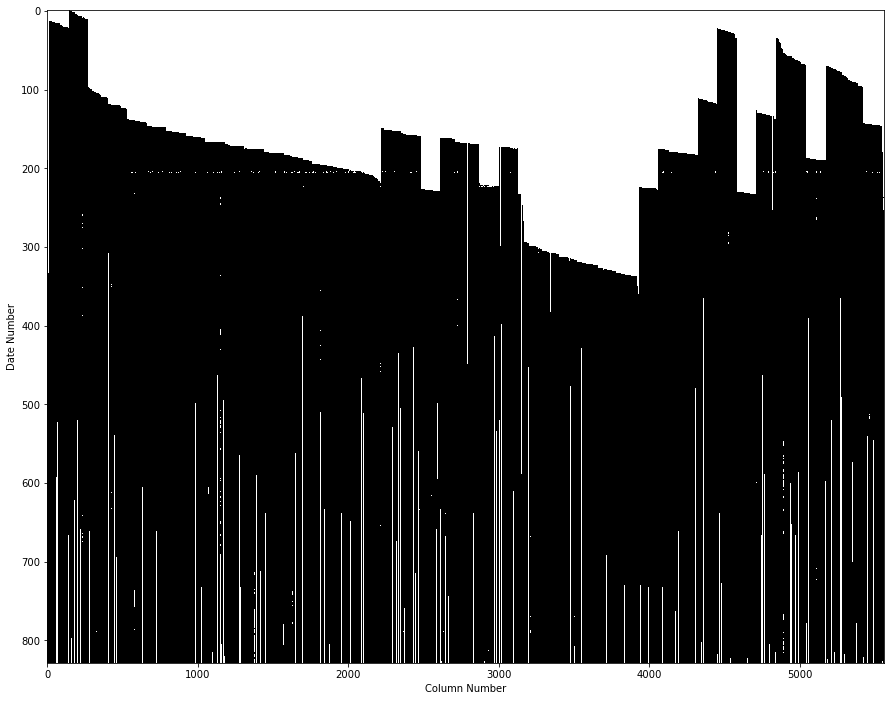

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
plt.imshow(summary_table.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Date Number");

Despite a slightly patchy data coverage, averaging by tariff type across all households for each day should give us a useful comparison.

In [29]:
daily_mean_by_tariff_type = saved_daily_summary.pivot_table(
    'kWh',
    index='Date',
    columns='Tariff Type',
    aggfunc='mean'
)
daily_mean_by_tariff_type.head()

Tariff Type,Std,ToU
Date,,
2011-11-23,7.430000,4.327500
2011-11-24,8.998333,6.111750
2011-11-25,10.102885,6.886333
2011-11-26,10.706257,7.709500
2011-11-27,11.371486,7.813500


Finally we can plot the two sets of data.

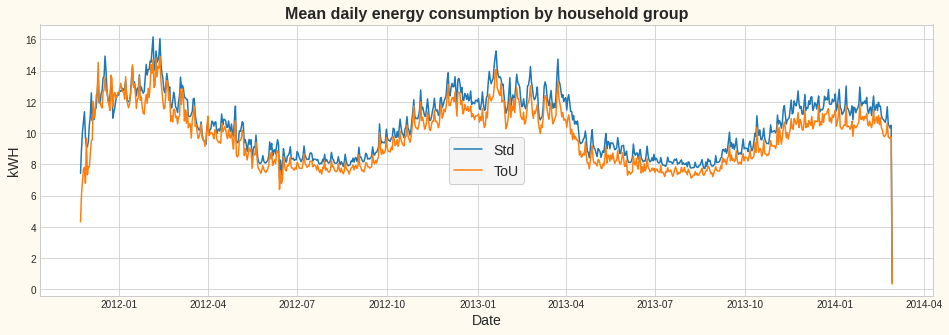

In [35]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(16, 5), facecolor='floralwhite')
for tariff in daily_mean_by_tariff_type.columns.to_list():
    plt.plot(
        daily_mean_by_tariff_type.index.values,
        daily_mean_by_tariff_type[tariff],
        label = tariff
    )

plt.legend(loc='center', frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14)
plt.title(
    'Mean daily energy consumption by household group',
    fontdict = {'fontsize' : 16, 'fontweight' : 'bold'}
)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('kWH', fontsize = 14)
plt.show()

The pattern looks seasonal which makes sense given heating energy demand.

It also looks like there's a difference between the two groups with the ToU group tending to consume less, but the display is too granular. Let's aggregate again into months.

In [31]:
daily_mean_by_tariff_type.index = pd.to_datetime(daily_mean_by_tariff_type.index)
daily_mean_by_tariff_type.head()

Tariff Type,Std,ToU
Date,,
2011-11-23,7.430000,4.327500
2011-11-24,8.998333,6.111750
2011-11-25,10.102885,6.886333
2011-11-26,10.706257,7.709500
2011-11-27,11.371486,7.813500


We can see that the data starts partway through November 2011, so we'll start from 1 December. It looks like the data finishes perfectly at the end of February, but the last value looks suspiciously low compared to the others. It seems likely the data finished part way through the last day. This may be a problem elsewhere in the data too, but it shouldn't have an enormous effect as at worst it will reduce the month's energy consumption for that household by two days (one at the beginning and one at the end).

In [32]:
monthly_mean_by_tariff_type = daily_mean_by_tariff_type['2011-12-01' : '2014-01-31'].resample('M').sum()
monthly_mean_by_tariff_type.head()

Tariff Type,Std,ToU
Date,,
2011-12-31,377.443042,365.391597
2012-01-31,401.744672,386.253703
2012-02-29,395.294296,368.663764
2012-03-31,349.367317,331.095386
2012-04-30,314.323216,297.032370


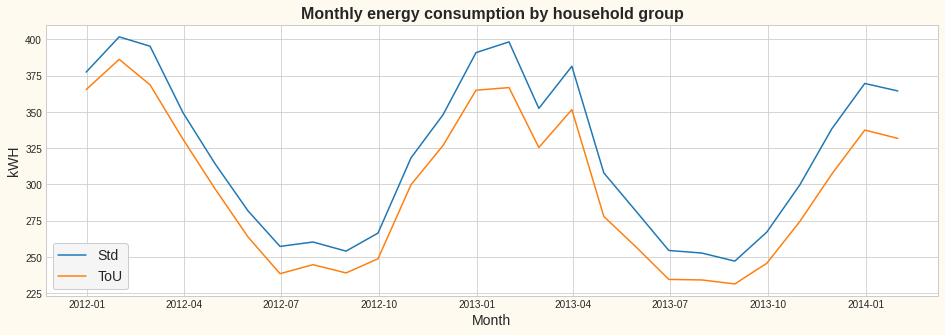

In [33]:
plt.figure(figsize=(16, 5), facecolor='floralwhite')
for tariff in daily_mean_by_tariff_type.columns.to_list():
    plt.plot(
        monthly_mean_by_tariff_type.index.values,
        monthly_mean_by_tariff_type[tariff],
        label = tariff
    )

plt.legend(loc='lower left', frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14)
plt.title(
    'Monthly energy consumption by household group',
    fontdict = {'fontsize' : 16, 'fontweight' : 'bold'}
)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('kWH', fontsize = 14)

# Uncomment for a copy to display in results
plt.savefig(fname='images/result1.png', bbox_inches='tight')

plt.show()

The pattern is much clearer and there is an obvious difference between the two groups of consumers.

Note that the chart does not show mean monthly energy consumption, but the sum over each month of the daily means. To calculate true monthly means we would need to drop the daily data for each household where the data was incomplete for a month. Our method should give a reasonable approximation.

Lastly we close the Dask client although it will automatically close when our Python session ends.

In [34]:
client.close()